In [1]:
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import orbit
from orbit.models import DLT,ETS, KTRLite, LGT, ARMA
from orbit.utils.simulation import make_trend, make_regression
import torch
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components


In [20]:
from datetime import datetime, timedelta
import datetime as dt 


In [3]:
%load_ext autoreload
%autoreload 2

<class 'numpy.ndarray'>


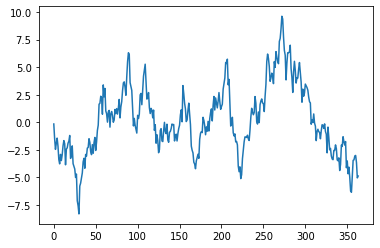

In [191]:
# make the data
n = 365 # hourly for 1 year 

x0 = np.random.normal(0, 1, n)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 1, n)
x3 = np.random.normal(0, 1, n)
x4 = np.random.normal(0, 1, n)
x5 = np.random.normal(0, 1, n)
x6 = np.random.normal(0, 1, n)
x7 = np.random.normal(0, 1, n)
x8 = np.random.normal(0, 1, n)
x9 = np.random.normal(0, 1, n)

X = np.vstack([x0, x1]).transpose()
   
    

eta = np.random.normal(0, 1.0, n)

rho = [0.95, -0.0025,0.0025]
beta = [0.00, -0.00]
y = eta.copy()
for i in range(2, n):
    y[i] = rho[0]*y[i-1] + rho[1]*y[i-2] + rho[2]*y[i-7] + x0[i]*beta[0]+ x1[i]*beta[1]+ eta[i]

     
#plt.plot(y)
plt.plot(y[1:500])
print(type(X))

In [192]:
def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta
        
hours = [datetime(2013, 1, 1, 14, 00)]        

start_date = datetime(2021, 1, 1, 00, 00)
end_date = datetime(2022, 1, 1, 00, 00)
i = 0
for single_date in daterange(start_date, end_date):
    hours[i]=hours.append(single_date.strftime("%Y-%m-%d %H:%M"))       
    i += i
hours = hours[1:(n+1)]
hours = [dt.datetime.strptime(hour, "%Y-%m-%d %H:%M") for hour in hours]


In [193]:
df = pd.DataFrame(X, columns=['a1', 'a2'])
df['hours'] = hours
df['y'] = y

In [194]:
df_train = df.iloc[0:180,:]
df_test = df.iloc[180:n,:]


In [195]:
mod = ARMA(
        #regressor_col=['a1', 'a2'],
        lm_first=0,
        estimator='stan-mcmc',
        date_col = 'hours',
        response_col = 'y',
        num_of_ar_lags = 1,
        ar_lags = [1],
        #num_of_ma_lags = 1,
        #ma_lags = [1] ,
    num_warmup=2000,
    num_sample=2000,

)

In [196]:
mod.fit(df_train)


Gradient evaluation took 0.000304 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.04 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000211 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.11 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000242 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.42 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.00019 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.9 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (War

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 87)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 87)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 0.148021 seconds (Warm-up)
               0.132816 seconds (Sampling)
               0.280837 seconds (Total)

Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 0.161344 seconds (Warm-up)
               0.131376 seconds (Sampling)
               0.29272 seconds (Total)

Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 0.159125 seconds (Warm-up)
               0.138926 seconds (Sampling)
               0.298051 seconds (Total)

It

In [197]:
pred = mod.predict(df)

hours
                  hours  prediction_5  prediction  prediction_95
0   2021-01-01 00:00:00     -1.611691   -0.024038       1.538566
1   2021-01-01 01:00:00     -1.659823   -0.041914       1.531970
2   2021-01-01 02:00:00     -1.697025   -0.194062       1.348112
3   2021-01-01 03:00:00     -2.993415   -1.404756       0.154108
4   2021-01-01 04:00:00     -3.850620   -2.269075      -0.699193
..                  ...           ...         ...            ...
360 2021-01-16 00:00:00     -5.625904   -0.464474       4.494710
361 2021-01-16 01:00:00     -5.522313   -0.562302       4.381497
362 2021-01-16 02:00:00     -5.656503   -0.577553       4.533464
363 2021-01-16 03:00:00     -5.551569   -0.541470       4.515085
364 2021-01-16 04:00:00     -5.664172   -0.510648       4.285047

[365 rows x 4 columns]
0     2021-01-01 00:00:00
1     2021-01-01 01:00:00
2     2021-01-01 02:00:00
3     2021-01-01 03:00:00
4     2021-01-01 04:00:00
              ...        
360   2021-01-16 00:00:00
361   20

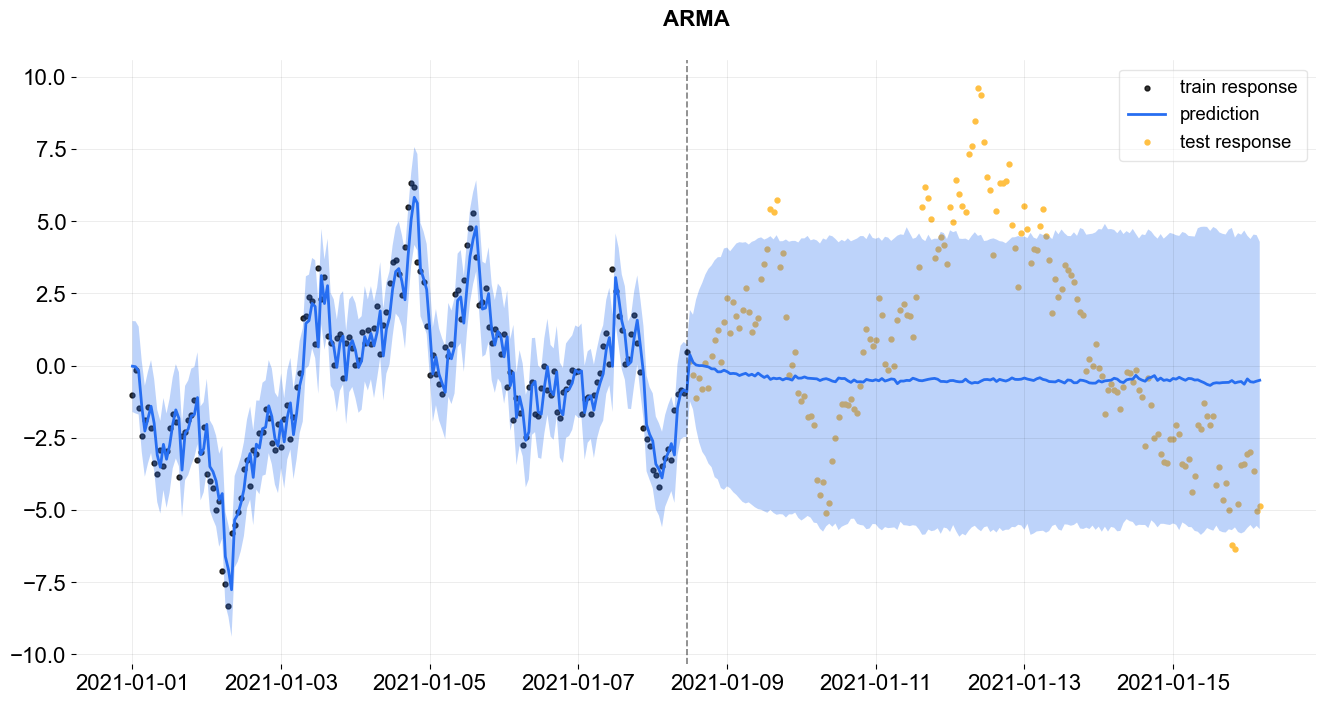

In [198]:

_ = plot_predicted_data(df_train, pred, date_col = 'hours', actual_col = 'y', title='ARMA', test_actual_df = df_test)

In [69]:
np.std(pred.iloc[8700:n,3]-df_test['y'])

4.207372571570419

In [199]:
mod.get_regression_coefs

functools.partial(<bound method ARMAModel.get_regression_coefs of <orbit.template.arma.ARMAModel object at 0x148994c50>>, {'response': array([-1.00917106e+00, -1.54525352e-01, -1.48535842e+00, -2.45672479e+00,
       -1.89307536e+00, -1.43683013e+00, -2.16408288e+00, -3.38200386e+00,
       -3.77077280e+00, -2.91108674e+00, -3.47343208e+00, -2.96799778e+00,
       -2.14923009e+00, -1.66243878e+00, -1.94239785e+00, -3.85480891e+00,
       -2.42612258e+00, -2.31702623e+00, -1.89239358e+00, -1.71245616e+00,
       -1.19543962e+00, -3.27694104e+00, -3.00519339e+00, -2.14083597e+00,
       -3.75170459e+00, -3.98855311e+00, -4.23523709e+00, -5.00519010e+00,
       -4.69471838e+00, -7.11755265e+00, -7.56900856e+00, -8.31084989e+00,
       -5.78360107e+00, -5.52163737e+00, -5.08344445e+00, -4.59389313e+00,
       -3.59055360e+00, -3.26494344e+00, -4.16774212e+00, -2.91724996e+00,
       -3.07088640e+00, -2.33549954e+00, -2.28592555e+00, -1.49057549e+00,
       -1.82635246e+00, -2.67025174e+00,

In [171]:
1.0/(1.0-0.5**2)

1.3333333333333333